In [14]:
import numpy as np
import os
from pathlib import Path
import cv2

## Data Preparation

In [60]:
p = Path("../../CB - ML/DATASETS/images")

dirs = p.glob("*")

labels_dict = {"cat":0,"dog":1,"horse":2,"human":3}
image_data = []
labels = []

for folder_dir in dirs:
    label = str(folder_dir).split('\\')[-1][:-1]
    
    for img_path in folder_dir.glob("*.jpg"):
        img = cv2.resize(cv2.imread(str(img_path)), (32,32))
        image_data.append(img)
        labels.append(labels_dict[label])

In [61]:
# Convert the data to numpy array

image_data = np.array(image_data,dtype='float32')/255.0
labels = np.array(labels)

In [62]:
print(image_data.shape)
print(labels.shape)

(808, 32, 32, 3)
(808,)


## Random Shuffling

In [63]:
import random

combined = list(zip(image_data,labels))
random.shuffle(combined)

# Unzip
image_data[:],labels[:] = zip(*combined)  # the '*' is used to unzip data

## Visualize data

In [26]:
from matplotlib import pyplot as plt

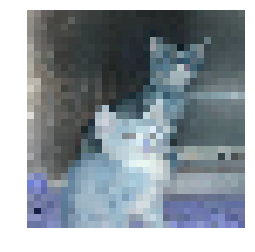

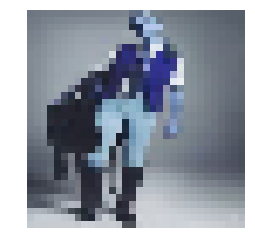

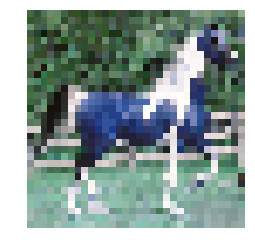

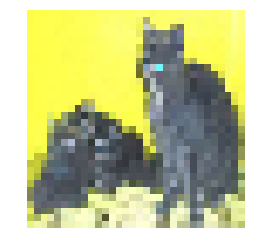

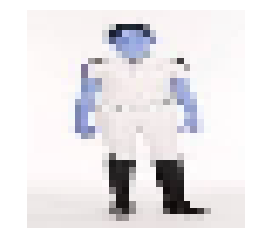

In [64]:
def drawImage(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
for i in range(5):
    drawImage(image_data[i])

## SVM Classifier

In [57]:
class SVM:
    
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hinge_loss(self,W,b,X,Y):
        loss = 0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C*max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=100,learning_rate=0.001,maxItr=300):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        # Init the model parameters
        
        W = np.zeros((1,no_of_features))
        bias = 0
        
        # Training from here...
        # Weight and Bias update rule
        
        losses = []
        
        for itr in range(maxItr):
            # Training loop
            
            l = self.hinge_loss(W,bias,X,Y)
            losses.append(l)
            
            # Batch Gradient Descent with random shuffling
            
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            for batch_start in range(0,no_of_samples,batch_size):
                # Assume zero gradient for the batch
                gradw = 0
                gradb = 0
                
                # Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti = Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                # Gradient for the batch is ready
                W = W - n*W + n*gradw
                bias = bias + n*gradb
        
        self.W = W
        self.b = bias
        return W,bias,losses

## Converting data for one vs one classification

In [65]:
M = image_data.shape[0]

image_data = image_data.reshape(M,-1)
print(image_data.shape)
print(labels.shape)

(808, 3072)
(808,)


In [66]:
CLASSES = len(np.unique(labels))
print(CLASSES)

4


In [67]:
def classWiseData(x,y):
    data = {}
    
    for i in range(CLASSES):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
    
    return data

In [68]:
data = classWiseData(image_data,labels)

In [71]:
print(data[0].shape)

(202, 3072)


In [72]:
# Combine data of two classes

def getDataPairForSVM(d1,d2):
    
    l1,l2 = d1.shape[0],d2.shape[0]
    
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = 1
    
    return data_pair,data_labels

## Training our classifiers

In [98]:
mySVM = SVM()

In [97]:
def trainSVMs(x,y):
    
    svm_classifiers = {}
    for i in range(CLASSES):
        svm_classifiers[i] = {}
        for j in range(i+1,CLASSES):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair,ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifiers[i][j] = (wts,b)
            
            plt.plot(loss)
            plt.show()
            
    return svm_classifiers

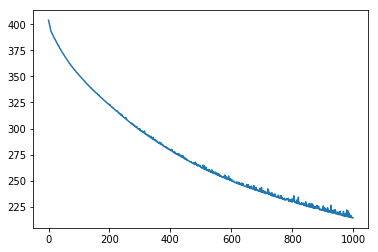

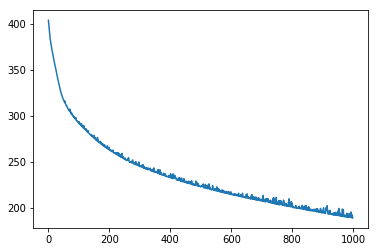

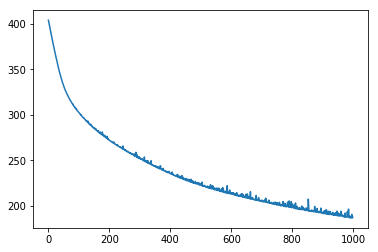

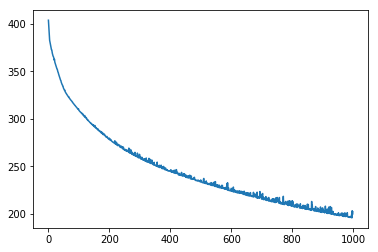

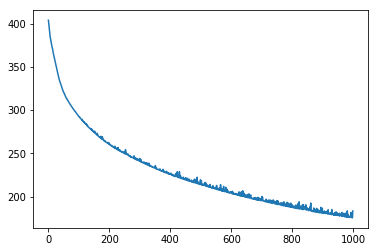

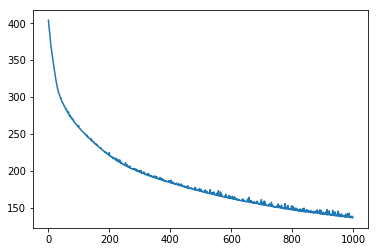

In [99]:
svm_classifiers = trainSVMs(image_data,labels)

## Predictions

In [100]:
def binaryPredict(x,w,b):
    z = np.dot(x,w.T)+b
    if z>=0:
        return 1
    else:
        return -1

In [101]:
def predict(x):
    
    count = np.zeros((CLASSES,))
    
    for i in range(CLASSES):
        for j in range(i+1,CLASSES):
            w,b = svm_classifiers[i][j]
            # Take a majority prediction
            z = binaryPredict(x,w,b)
            
            if z==1:
                count[j] += 1
            else:
                count[i] += 1
                
    final_prediction = np.argmax(count)
    return final_prediction

## Accuracy

In [102]:
def accuracy(x,y):
    
    count = 0
    
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if prediction == y[i]:
            count += 1
    
    return count/x.shape[0]

In [103]:
accuracy(image_data,labels)

0.5928217821782178

## Comparing the accuracy with inbuilt library

In [104]:
from sklearn import svm

In [105]:
svc = svm.SVC(kernel='linear',C=1.0)

In [106]:
svc.fit(image_data,labels)
svc.score(image_data,labels)

0.63985148514851486